# Forecasting using ARIMA type methods 
* Use SACTYPE as clustering group.
* Perform linear regression for each SACTYPE group, compare the significance \& effect sizes of each variable.
* From the case comp website https://ssc.ca/en/case-study/towards-a-clear-understanding-rural-internet-what-statistical-measures-can-be-used-assess:
    * For comparing rural and municipal internet speeds, it may be important to consider the following:

        * Whether the tile is labelled with a population centre or not;
        * SACTYPE - which provides information on the level of municipal influence as defined by Statistics Canada; and/or,
        * Whether a population centre is a small, medium or large (PCCLASS), or its type classification (PCTYPE). For example, it may be interesting to contrast results from small population centres in the rural areas against large population centres.
* Description of the SACTYPEs:
    1. Census subdivision within census metropolitan area
    2. Census subdivision within census agglomeration with at least one census tract
    3. Census subdivision within census agglomeration having no census tracts
    4. Census subdivision outside of census metropolitan area and census agglomeration area having strong metropolitan influence
    5.	Census subdivision outside of census metropolitan area and census agglomeration area having moderate metropolitan influence
    6.	Census subdivision outside of census metropolitan area and census agglomeration area having weak metropolitan influence
    7.	Census subdivision outside of census metropolitan area and census agglomeration area having no metropolitan influence
    8.	Census subdivision within the territories, outside of census agglomeration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install geopandas rtree &> /dev/null 

Mounted at /content/drive


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from importlib import reload

import sys
sys.path.append(os.path.abspath("/content/drive/MyDrive/shared/ssc22-case-comp/sonny_dir/custom_modules"))
import weighted_average_ver3 as WA

## Load the source data
os.chdir('/content/drive/MyDrive/shared/ssc22-case-comp/')

with open('./dataset/can-speed-tiles-with-dist37.p', 'rb') as file:
  data = pickle.load(file)
print(data.info())

# extract rural (PCCLASS==NaN)
data =data[pd.isnull(data['PCCLASS'])]

data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2751464 entries, 0 to 2751463
Data columns (total 23 columns):
 #   Column      Dtype   
---  ------      -----   
 0   quadkey     int64   
 1   avg_d_kbps  int64   
 2   avg_u_kbps  int64   
 3   avg_lat_ms  int64   
 4   tests       int64   
 5   devices     int64   
 6   year        int64   
 7   quarter     object  
 8   conn_type   object  
 9   PRUID       int64   
 10  PRNAME      object  
 11  CDUID       int64   
 12  CDNAME      object  
 13  DAUID       int64   
 14  SACTYPE     int64   
 15  DA_POP      float64 
 16  PCUID       float64 
 17  PCNAME      object  
 18  PCTYPE      float64 
 19  PCCLASS     float64 
 20  geometry    geometry
 21  centroid    object  
 22  distance    float64 
dtypes: float64(5), geometry(1), int64(11), object(6)
memory usage: 482.8+ MB
None
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1498904 entries, 0 to 2751463
Data columns (total 23 columns):
 #   Column      Non-Null

In [5]:
reload(WA)

group = 'SACTYPE'

groups = sorted(data[group].unique())

w_dist2 = WA.w_avg2(data, group_col = group, to_avg=['avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'distance'], to_w_sum =['DA_POP'], to_sum=['devices'], weight='tests').sort_values(by=['SACTYPE', 'time']).reset_index(drop=True)
# w_dist2 = WA.w_avg2(data, group_col = group, to_avg=['avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'distance'], to_w_sum = ['PRUID'], to_sum=['DA_POP','devices'], weight='tests').sort_values(by=['SACTYPE', 'time']).reset_index(drop=True)
w_dist_out = w_dist2.copy()
w_dist_out['avg_d_mbps'] = w_dist_out['avg_d_kbps']/1000
w_dist_out['avg_u_mbps'] = w_dist_out['avg_u_kbps']/1000
w_dist_out = w_dist_out.drop(columns=['avg_d_kbps', 'avg_u_kbps'])
w_dist_out['devices'] = pd.to_numeric(w_dist_out['devices'])
w_dist_out['tests'] = pd.to_numeric(w_dist_out['tests'])

## change the time variables format to datetime
from datetime import datetime 
d_data = w_dist_out.copy()
years = list(range(2019, 2022))
months = ['03-31', '06-30', '09-30', '12-31']
year_months = []
for year in years:
    for month in months:
        year_months.append(str(year) + '-' + month)
year_quarters = sorted(d_data['time'].unique())

d_data['time'] = d_data['time'].replace(dict(zip(year_quarters, year_months)))
d_data['time'] = pd.to_datetime(d_data['time'])
d_data['time'] = pd.to_datetime(d_data['time'], format('%Y-%m'))

## convert some variables to categorical variables
d_data[group] = d_data[group].astype('category')
d_data['conn_type'] = d_data['conn_type'].astype('category')
print(d_data.info())

with open('./sonny_dir/can-w-avg-by-sactype-rural.p', 'wb') as file:
    pickle.dump(d_data, file)


## split training set and validation set
val_time = year_months[-1]
train_idx = d_data['time'] != val_time
val_idx = d_data['time'] == val_time
train_set = d_data.loc[train_idx, :].reset_index(drop=True)
val_set = d_data.loc[val_idx, :].reset_index(drop=True)

# create a subset to store true values and forecasts
f_set = val_set[[group, 'conn_type', 'avg_d_mbps']].sort_values(by=[group, 'conn_type']).reset_index(drop=True)

# As we train & make forecasts, create a column for that model and store it.
# for example, 
# f_set['model1'] = preds
# f_set

# create a dataframe to store the errors
mse_df = pd.DataFrame(val_set.loc[:,[group, 'conn_type']])
mse_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   SACTYPE     192 non-null    category      
 1   conn_type   192 non-null    category      
 2   time        192 non-null    datetime64[ns]
 3   avg_lat_ms  192 non-null    float64       
 4   distance    192 non-null    float64       
 5   DA_POP      192 non-null    float64       
 6   devices     192 non-null    int64         
 7   tests       192 non-null    int64         
 8   avg_d_mbps  192 non-null    float64       
 9   avg_u_mbps  192 non-null    float64       
dtypes: category(2), datetime64[ns](1), float64(5), int64(2)
memory usage: 13.0 KB
None


,SACTYPE,conn_type
0,1,fixed
1,1,mobile
2,2,fixed
3,2,mobile
4,3,fixed
5,3,mobile
6,4,fixed
7,4,mobile
8,5,fixed
9,5,mobile


Statistics=0.951, p=0.000


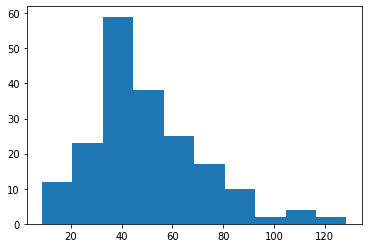

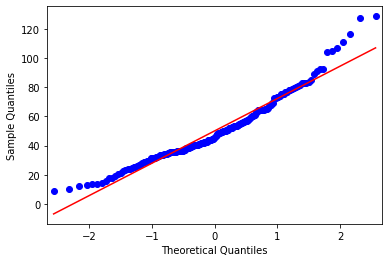

In [14]:
plt.hist(data_lin['avg_d_mbps'])

from statsmodels.graphics.gofplots import qqplot
qqplot(data_lin['avg_d_mbps'], line='s')

from scipy.stats import shapiro
## H0: not normally distributed
stat, p = shapiro(data_lin['avg_d_mbps'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

In [8]:
## Linear regression on the entire data
import statsmodels.api as sm

# Prepare data
### one-hot encode the categories
data_onehot = pd.get_dummies(data = d_data, columns = [group, 'conn_type'], drop_first=True) # drop_first gives k-1 dummy variables instead of k

train_x = data_onehot.loc[train_idx, :].drop(columns=['avg_d_mbps'])
train_y = data_onehot.loc[train_idx, 'avg_d_mbps']
val_x = data_onehot.loc[val_idx, :].drop(columns=['avg_d_mbps'])
val_y = data_onehot.loc[val_idx, 'avg_d_mbps']

data_lin = data_onehot.copy()

### Make time a numerical variable
times = sorted(d_data.loc[:,'time'].unique())
time_ints = [*range(1,len(times)+1)]
data_lin.loc[:,'time_int'] = data_lin.loc[:,'time'].replace(to_replace=times, value = time_ints)
data_lin = data_lin.drop(columns = ['time', 'avg_lat_ms', 'avg_u_mbps','tests'])
# data_lin = sm.add_constant(data_lin)

### Split train, val data
lin_train_set = data_lin.loc[train_idx, :]
lin_x_train = lin_train_set.drop(columns=['avg_d_mbps'])
lin_y_train = lin_train_set[['avg_d_mbps']]

lin_val_set = data_lin.loc[val_idx, :]
lin_x_valid = lin_val_set.drop(columns=['avg_d_mbps'])
lin_y_valid = lin_val_set.loc[:,'avg_d_mbps']

### Fit linear regression model
# new_x_train = sm.add_constant(lin_x_train)
new_x_train = lin_x_train
OLS_model1 = sm.OLS(np.asarray(lin_y_train), new_x_train ).fit()

### make predictions
# new_x_valid = sm.add_constant(lin_x_valid)
new_x_valid = lin_x_valid
OLS_preds = OLS_model1.predict(new_x_valid)
f_set['LR'] = OLS_preds

# ## compute errors
# ### Compute rmse
from statsmodels.tools.eval_measures import rmse

lr_rmse = rmse(lin_y_valid, OLS_preds)

print(lr_rmse)

20.679325398721637


In [9]:
OLS_model1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.951    
Dependent Variable:     y                AIC:                         1370.3969
Date:                   2022-04-28 16:42 BIC:                         1408.4428
No. Observations:       176              Log-Likelihood:              -673.20  
Df Model:               12               F-statistic:                 284.5    
Df Residuals:           164              Prob (F-statistic):          4.82e-103
R-squared (uncentered): 0.954            Scale:                       131.99   
---------------------------------------------------------------------------------
                       Coef.     Std.Err.      t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------------
distance                0.0264     0.0452    0.5843   0.5598    -0.0628    0.1156
DA_POP                  0.0169     0.0024    6.8867   0.0000     0.0120    0.0217
devices                 0.0007     0.0001    8.7694   0.0000     0.0005    0.0008
SACTYPE_2              32.6874     3.0436   10.7398   0.0000    26.6778   38.6971
SACTYPE_3              14.1589     2.9016    4.8796   0.0000     8.4295   19.8882
SACTYPE_4              -7.3394     3.0547   -2.4027   0.0174   -13.3710   -1.3079
SACTYPE_5              -9.6911     3.1832   -3.0445   0.0027   -15.9764   -3.4058
SACTYPE_6               4.5866     3.0836    1.4874   0.1388    -1.5020   10.6752
SACTYPE_7               7.4526     3.5821    2.0805   0.0390     0.3797   14.5255
SACTYPE_8             -11.5098     9.1578   -1.2568   0.2106   -29.5922    6.5726
conn_type_mobile       10.7718     2.2384    4.8122   0.0000     6.3519   15.1916
time_int                2.8031     0.2789   10.0515   0.0000     2.2525    3.3538
-------------------------------------------------------------------------------
Omnibus:                  25.810            Durbin-Watson:               2.242 
Prob(Omnibus):            0.000             Jarque-Bera (JB):            55.825
Skew:                     -0.655            Prob(JB):                    0.000 
Kurtosis:                 5.428             Condition No.:               242369
===============================================================================
* The condition number is large (2e+05). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [15]:
import statsmodels.api as sm
## Perform linear regression on each SACTYPE

### Prepare data

# one-hot encode the categories
data_onehot = pd.get_dummies(data = d_data, columns = ['conn_type'], drop_first=True) # drop_first gives k-1 dummy variables instead of k

# train_x = data_onehot.loc[train_idx, :].drop(columns=['avg_d_mbps'])
# train_y = data_onehot.loc[train_idx, 'avg_d_mbps']
# val_x = data_onehot.loc[val_idx, :].drop(columns=['avg_d_mbps'])
# val_y = data_onehot.loc[val_idx, 'avg_d_mbps']

times = sorted(d_data.loc[:,'time'].unique())
time_ints = [*range(1,len(times)+1)]

data_lin = data_onehot.copy()
data_lin.loc[:,'time_int'] = data_lin.loc[:,'time'].replace(to_replace=times, value = time_ints)
data_lin = data_lin.drop(columns = ['time', 'avg_lat_ms', 'avg_u_mbps', 'tests'])

sactypes = data_lin['SACTYPE'].unique()
# sactypes = [1.0, 2.0]

ols_models = {}
ols_preds = []
for s in sactypes:
    print('processing sactype {s}'.format(s=s))
    lin_subset = data_lin.loc[data_lin['SACTYPE'] == s, :]
    # lin_subset = sm.add_constant(lin_subset)
    subset_x = lin_subset.drop(columns=['SACTYPE', 'avg_d_mbps']).reset_index(drop=True)
    subset_y = lin_subset[['avg_d_mbps']].reset_index(drop=True)

    subset_x_train = subset_x.iloc[0:-1]
    subset_y_train = subset_y.iloc[0:-1]

    subset_x_val = subset_x.iloc[[-1]]
    subset_y_val = subset_y.iloc[[-1]]

    new_x_train = subset_x_train
    ols_model = sm.OLS(np.asarray(subset_y_train), new_x_train).fit()
    # ols_model.fit()
    ols_models[s] = ols_model
    print(ols_model.predict(subset_x_val))


processing sactype 1
23    79.104752
dtype: float64
processing sactype 2
23    84.704025
dtype: float64
processing sactype 3
23    75.77468
dtype: float64
processing sactype 4
23    49.691633
dtype: float64
processing sactype 5
23    58.753103
dtype: float64
processing sactype 6
23    77.326961
dtype: float64
processing sactype 7
23    56.336756
dtype: float64
processing sactype 8
23    44.839846
dtype: float64


In [16]:
aa = ols_models[7.0]
OLSresult = (aa.summary2().tables[1])
OLSresult

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
distance,0.222421,0.447728,0.496778,0.625358,-0.718220,1.163063
DA_POP,-0.014265,0.061640,-0.231431,0.819590,-0.143765,0.115235
devices,0.003894,0.003856,1.009851,0.325950,-0.004207,0.011996
conn_type_mobile,22.180431,10.852265,2.043853,0.055883,-0.619332,44.980193
time_int,2.264016,0.722411,3.133972,0.005736,0.746287,3.781746


In [ ]:
from sklearn.ensemble import RandomForestRegressor

lin_x_train = lin_train_set.drop(columns=['avg_d_mbps'])
lin_y_train = lin_train_set[['avg_d_mbps']]

regressor = RandomForestRegressor(n_estimators=20, 
                                  random_state=0,
                                  oob_score=True)
regressor.fit(lin_x_train, lin_y_train)
y_pred = regressor.predict(lin_x_valid)
y_pred
RF_oob_score = regressor.oob_score_
RF_rmse = np.sqrt(np.sum(np.square(y_pred - f_set['avg_d_mbps'])) / len(f_set))
print(RF_oob_score)
print(RF_rmse)

0.8366587072801908
21.210798072911334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=100, 
                                 learning_rate=0.1,
                                 random_state=0).fit(lin_x_train, lin_y_train)
gbr_pred = gbr.predict(lin_x_valid)
print(gbr.score(lin_x_valid, lin_y_valid))
gbr_rmse = np.sqrt(np.sum(np.square(gbr_pred - f_set['avg_d_mbps']))/len(f_set) )
print(gbr_rmse)

0.8137948583584116
18.184225599952413


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


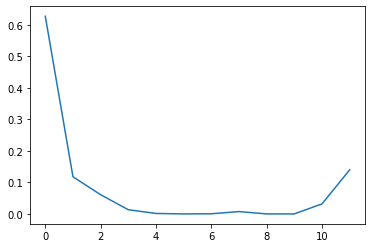

In [ ]:
plt.plot(gbr.feature_importances_)

In [ ]:
gbr.feature_names_in_

array(['distance', 'DA_POP', 'devices', 'SACTYPE_2', 'SACTYPE_3',
       'SACTYPE_4', 'SACTYPE_5', 'SACTYPE_6', 'SACTYPE_7', 'SACTYPE_8',
       'conn_type_mobile', 'time_int'], dtype=object)

In [ ]:
import lightgbm as ltb

ltb_reg = ltb.LGBMRegressor(n_estimators=100, 
                            learning_rate=0.1,
                            random_state=0
                            ).fit(lin_x_train, lin_y_train)
ltb_pred = ltb_reg.predict(lin_x_valid)
# print(ltb_reg.score(lin_x_valid, lin_y_valid))
ltb_rmse = np.sqrt(np.sum(np.square(ltb_pred - f_set['avg_d_mbps']))/len(f_set) )
print(ltb_rmse)

19.818212673764105


In [ ]:
test_data = lin_x_valid
aa = test_data.iloc[[10]]
aa['time_int'] = 200
aa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,distance,DA_POP,devices,SACTYPE_2,SACTYPE_3,SACTYPE_4,SACTYPE_5,SACTYPE_6,SACTYPE_7,SACTYPE_8,conn_type_mobile,time_int
142,14.937532,554.875231,26244,0,0,0,0,1,0,0,0,200


In [ ]:
gbr.predict(aa)

array([78.65519687])

In [ ]:
lin_y_train.iloc[10]

avg_d_mbps    115.797326
Name: 10, dtype: float64

In [ ]:
OLS_model1.predict(aa)

142    709.551164
dtype: float64